In [1]:
import imageio
import matplotlib.pyplot as plt
from matplotlib.pylab import cm
import numpy as np
from collections import OrderedDict
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

def draw_at_tile(farm_map, tile, color=[0,0,0,255], blend=False):
    farm = farm_map.copy()
    tile_size = 16
    x = slice(tile[0] * tile_size, (tile[0] + 1) * tile_size)
    y = slice(tile[1] * tile_size, (tile[1] + 1) * tile_size)
    if blend:
        # cast up then average
        farm = farm.astype(np.float)
        for i in range(4):
            farm[x,y,i] = (farm[x, y,i] * farm[x, y, 3] + color[i] * color[3]) / (farm[x,y,3] + color[3])        
        farm = farm.astype(np.uint8)
    else:
        farm[x, y] = color
    return farm

def draw_tiles(farm_map, tiles, color=None, blend=True):
    farm = farm_map.copy()
    n_tiles = len(tiles)
    if color is None:
        cmap = cm.get_cmap('jet', n_tiles) 
    for i in range(n_tiles):
        if color is None:
            col = (np.array(cmap(i))*255).astype(np.uint8)
            farm = draw_at_tile(farm, tiles[i], col)
        else:
            farm = draw_at_tile(farm, tiles[i], color, blend)            
    return farm

def build_cmap(N):
    base_cmap = cm.get_cmap('Set1',N)
    cmap = np.zeros((N,4),dtype=np.uint8)
    for i in range(N):
        cmap[i] = np.asarray(base_cmap(i))*255
    return cmap

In [2]:
def buildable_tiles():
    left_wall = {(9,3),(9,4),(10,3)}
    left_wall = left_wall.union([(x,y) for x in range(23,36+1) for y in range(3,6+1)])
    left_wall = left_wall.difference([(34,6),(35,5),(35,6),(36,4),(36,5),(36,6)])

    bottom_right = {(x,y) for x in range(56,61+1) for y in range(69,75+1) if x >= 59 or y >= 73}

    green_house = {(x,y) for x in range(10,17+1) for y in range(24,33+1)}
    green_house = green_house.difference({(17,24),(17,25)})
    green_house = green_house.union([(x,y) for x in range(9,10+1) for y in range(32,36+1)])

    house = {(x,y) for x in range(10,17+1) for y in range(58, 75+1)}
    house = house.union([(10+x,54+y) for x in range(4) for y in range(4) if x <= y])

    small_pond = {(x,y) for x in range(28,33+1) for y in range(70,75+1) if (x,y) not in [(33,70),(28,75),(33,75)]}

    big_pond = {(x,y) for x in range(49,58+1) for y in range(33,46+1)}
    big_pond = big_pond.difference({(49,33),(49,34),(49,35),(50,33),(50,34),(51,33)})
    big_pond = big_pond.difference({(55,33),(56,33),(57,33),(58,33),(57,34),(58,34),(57,35),(58,35),(58,36)})
    big_pond = big_pond.difference({(49,43),(49,44),(49,45),(49,46),(50,44),(50,45),(50,46),(51,46)})
    big_pond = big_pond.difference({(56,46),(57,45),(57,46),(58,42),(58,43),(58,44),(58,45),(58,46)})

    all_tiles = {(x,y) for x in range(9,61+1) for y in range(3,75+1)}

    all_tiles = all_tiles.difference(left_wall)
    all_tiles = all_tiles.difference(green_house)
    all_tiles = all_tiles.difference(house)
    all_tiles = all_tiles.difference(small_pond)
    all_tiles = all_tiles.difference(bottom_right)
    all_tiles = all_tiles.difference(big_pond)
    return np.array(list(all_tiles))

def render_hour(uniq_id, day, hour, write=True, draw=True):
    farm = hour_image(uniq_id, day, hour)
    farm[0:140,0:100] = [0,0,0,255]
    
    fig, ax = plt.subplots(figsize=(25,20))
    plt.imshow(farm)
    plt.xticks([])
    plt.yticks([])
    patches = []
    for i in range(6):
        plt.text(0,20+22*i,f'{hour:2d}:{i*10:02d}', fontdict={'color':'r','size':22, 'weight':'bold'})
        patches.append(Rectangle((65,2+i*22),30,20, color=build_cmap(6)[i].astype(np.float)/255.0))
    ax.add_collection(PatchCollection(patches,match_original=True))
    plt.tight_layout()
    if draw:
        print(f'ID:{uniq_id} Day:{day} Hour:{hour}')
        plt.show()
    if write:
        plt.savefig(f'{uniq_id}_{day}_{hour}.png')
    plt.close(fig)

def render_fullday(uniq_id, day, write=True, draw=True):
    tiles = buildable_tiles()
    cmap = build_cmap(6)
    farm = farm_map.copy()
    for hour in range(6,26+1):
        render_hour(uniq_id, day, hour, write, draw)
        
def hour_image(uniq_id, day, hour):
    tiles = buildable_tiles()
    seed_locs = ancient_seed_by_hour(uniq_id, day, hour, tiles)
    cmap = build_cmap(6)
    farm = farm_map.copy()
    for i,key in enumerate(seed_locs.keys()):
        farm = draw_tiles(farm, seed_locs[key], cmap[i], False)
    return farm

def ancient_seed_by_hour(uniq_id, day, hour, tiles):
    seed_locs = OrderedDict()
    # this is backwards due to the draw order
    y, x = np.asarray(tiles)[:,0], np.asarray(tiles)[:,1]
    random = lambda s: (0.8173253595909687 + s * 0.2934186175900598) % 1
    for i in range(6):
        time = hour*100 + 10*i
        seed = day + (uniq_id // 2) + x + y*77 + time
        locs = np.where(random(seed) < 0.005)[0]
        if locs is not None:
            seed_locs['{0:d}:{1:02d}'.format(hour,10*i)] = tiles[locs]
    return seed_locs

In [4]:
farm_map = imageio.imread('farm_map.png')

ID:100 Day:8 Hour:7


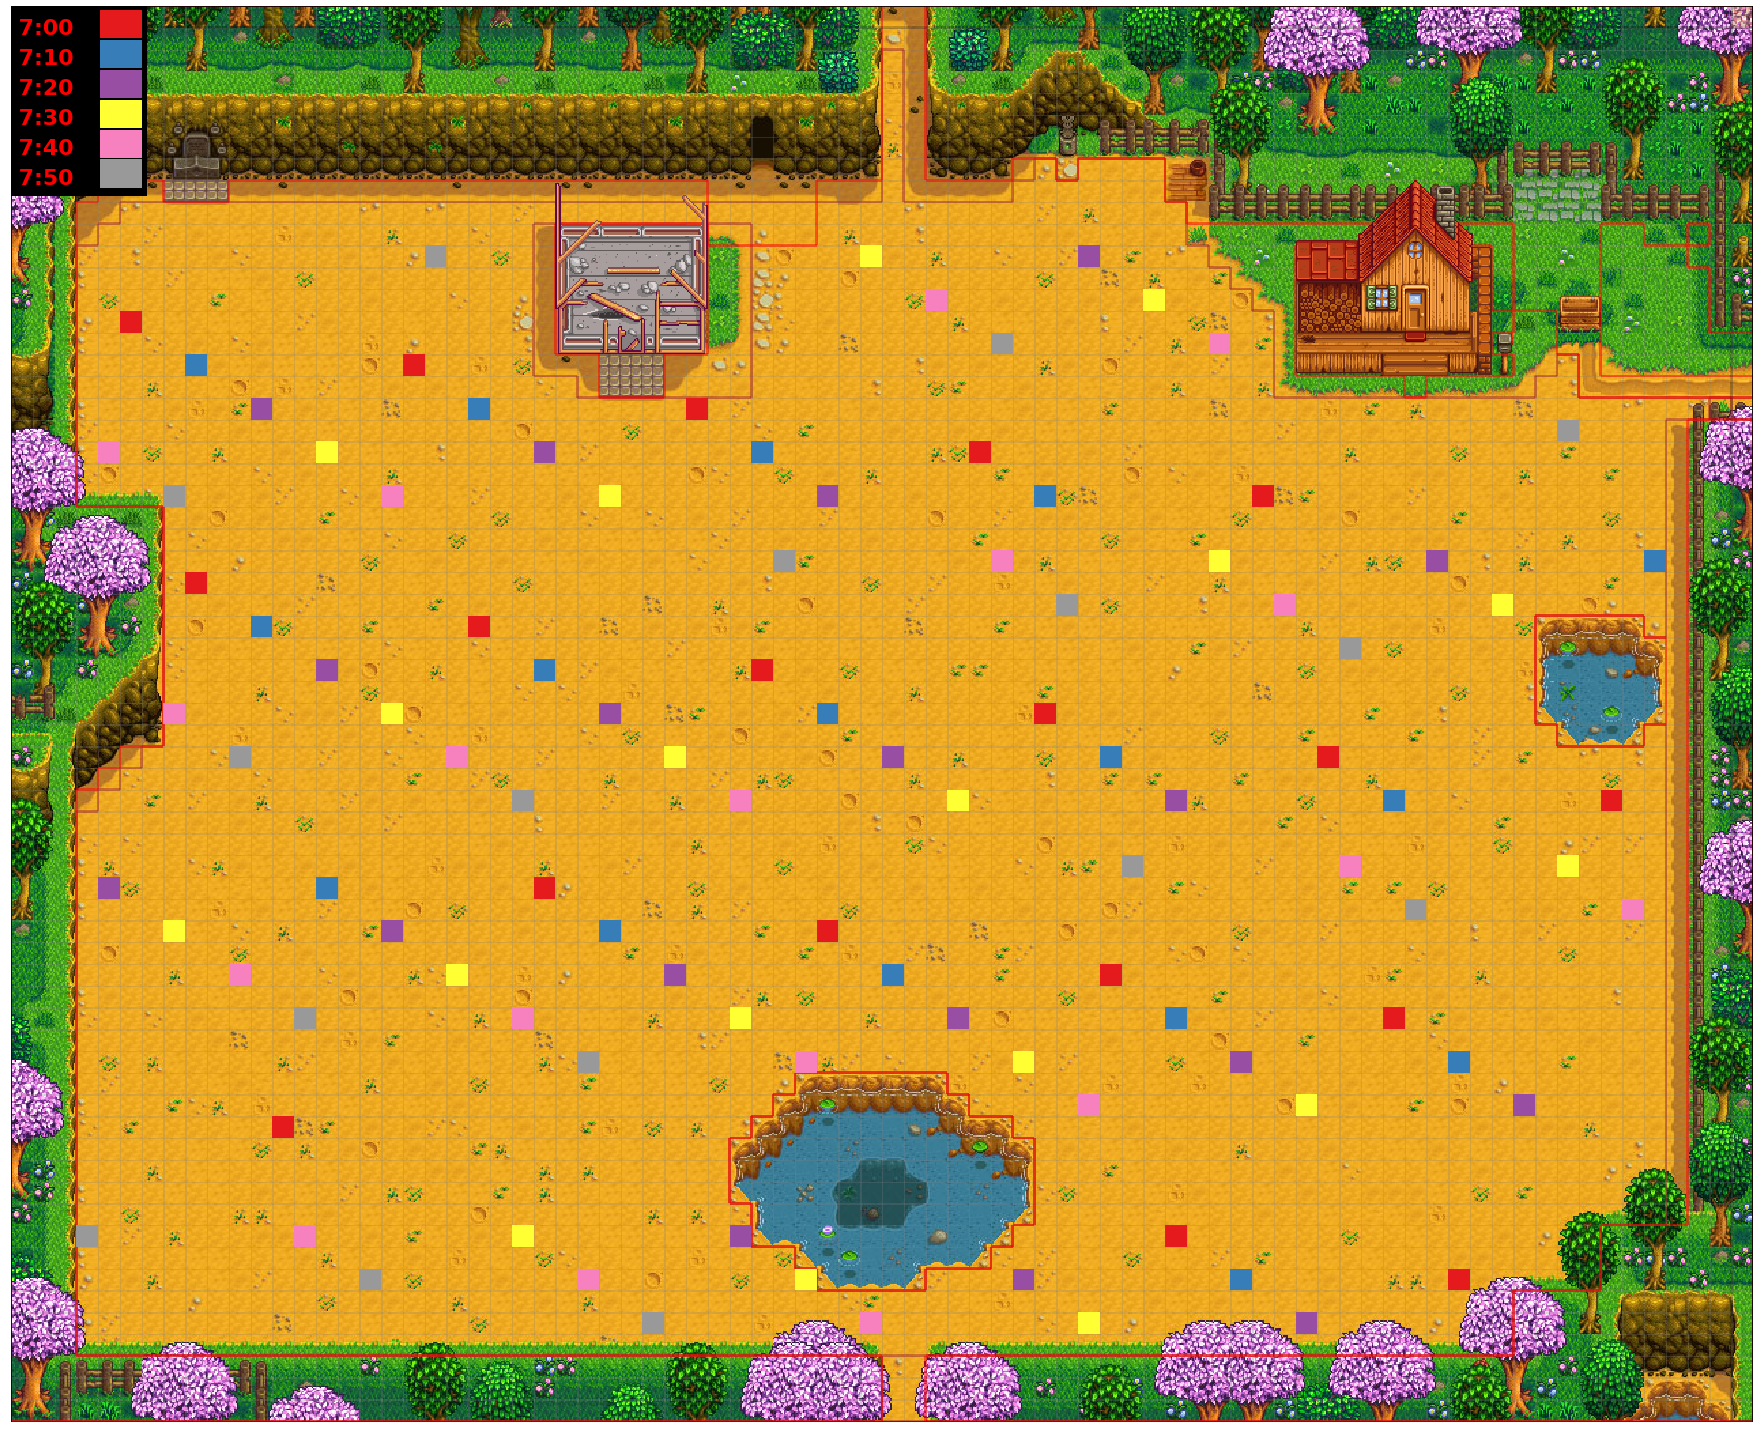

<Figure size 432x288 with 0 Axes>

In [6]:
uniq_id = 100
day = 8
hour = 7

render_hour(uniq_id, day, hour, write=True, draw=True)
render_fullday(uniq_id, day, write=True, draw=False)